In [7]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import random
import os

import dataloaders
import utils
from importlib import reload
import config
reload(config)
reload(utils)
reload(dataloaders)
from config import INPUT_SIZE, NUM_CLASSES, HIDDEN_SIZE, N_EPOCHS, LR, LR_DECAY, REG, BATCH_SIZE

In [2]:
# Weight initilization
#TO DO: We may try different initialization such as Xavier
def weights_init(m):
    if type(m) == nn.Linear:
        m.weight.data.normal_(0.0, 1e-3)
        m.bias.data.fill_(0.)

def update_lr(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [3]:
RANDOM_SEED = 42 

def set_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

set_seed(RANDOM_SEED)

Random seed set as 42


In [4]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device: %s'%device)

Using device: cpu


In [5]:
# Load the dataset
train_loader, val_loader, test_loader = dataloaders.create_dataloaders()

69
0 Index([6582, 7194, 9446, 4883, 8471, 9354, 8298, 7880, 4288, 3931, 4193, 5826,
       5741, 8218, 9162, 4153, 7954, 3209, 6974, 9544, 7998, 4645, 3661, 3387,
       9328, 4004, 7132, 8640, 5007, 6224, 7861, 6597, 8039, 3007, 8595, 5964,
       6398, 6088, 5263, 4165, 4513, 4392, 8391, 6067, 4393, 8955, 3848, 5064,
       6513, 7801, 7042, 5911, 6392, 6177, 7524, 8546, 3080, 3997, 9067, 9369,
       6458, 3319, 9539, 5807, 4189, 7323, 4734, 8650, 9258],
      dtype='int64')
1 Index([533, 132, 964, 168, 210, 718, 449, 810, 682,  46,  30, 810, 533, 168,
       964, 682, 810,  46, 533, 210, 533, 964, 718, 533, 964, 810, 718, 964,
       449, 682, 533, 682, 810, 168, 132,  30, 168, 132, 132,  46, 449, 682,
       682, 718,  30, 210, 449,  46, 449,  46, 449, 810, 533, 964, 168, 533,
       964, 132, 168, 449, 210, 210, 964, 964,  30, 810, 449, 132, 682],
      dtype='int64')
2 Index([9704, 9749, 9704, 9704, 9749, 9749, 9749, 9749, 9749, 9749, 9704, 9704,
       9704, 9704, 9704, 9749, 9

Loading train images: 414it [00:02, 174.54it/s]


Len stack: 345
Loading complete, some files (0) were not found: []


Loading test images: 100it [00:00, 201.97it/s]


Len stack: 100
Loading complete, some files (0) were not found: []


Loading test images: 100it [00:00, 205.06it/s]

Len stack: 100
Loading complete, some files (0) were not found: []


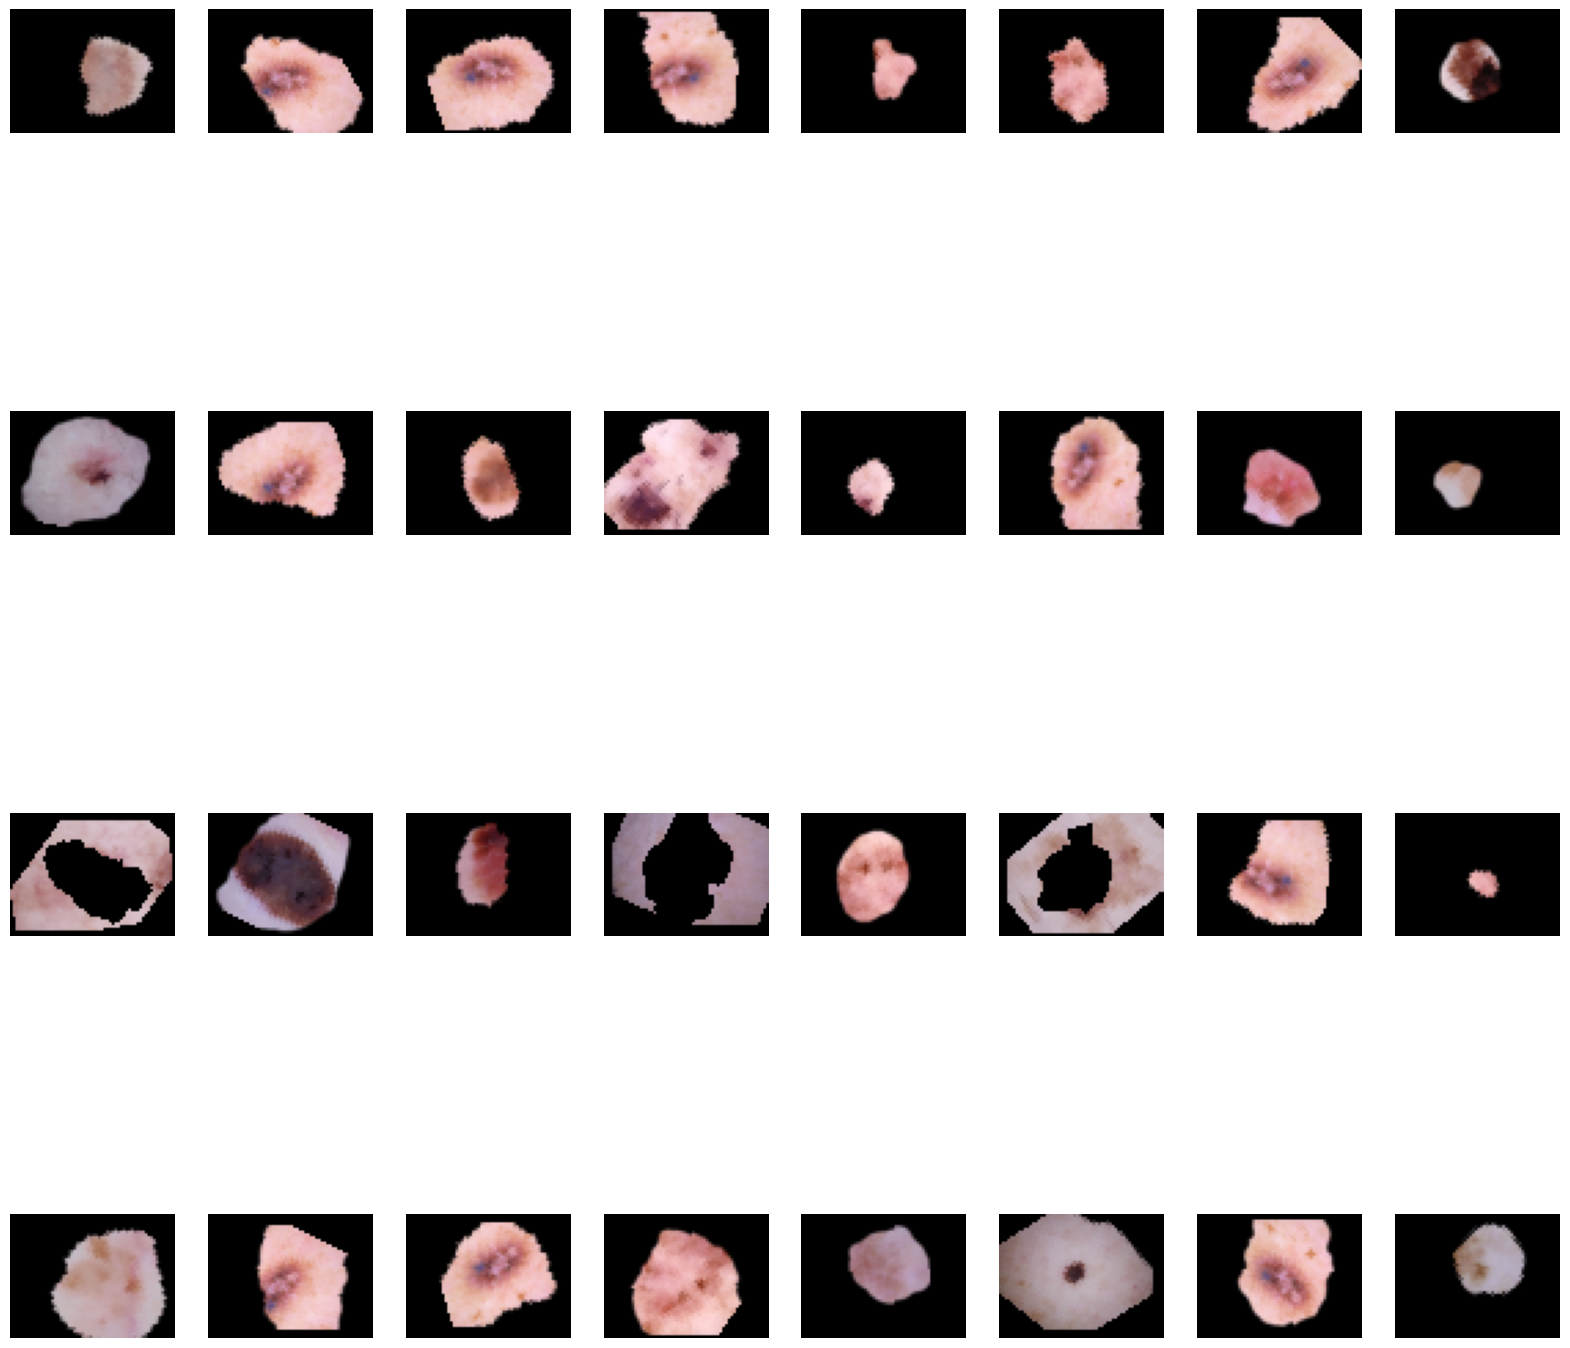

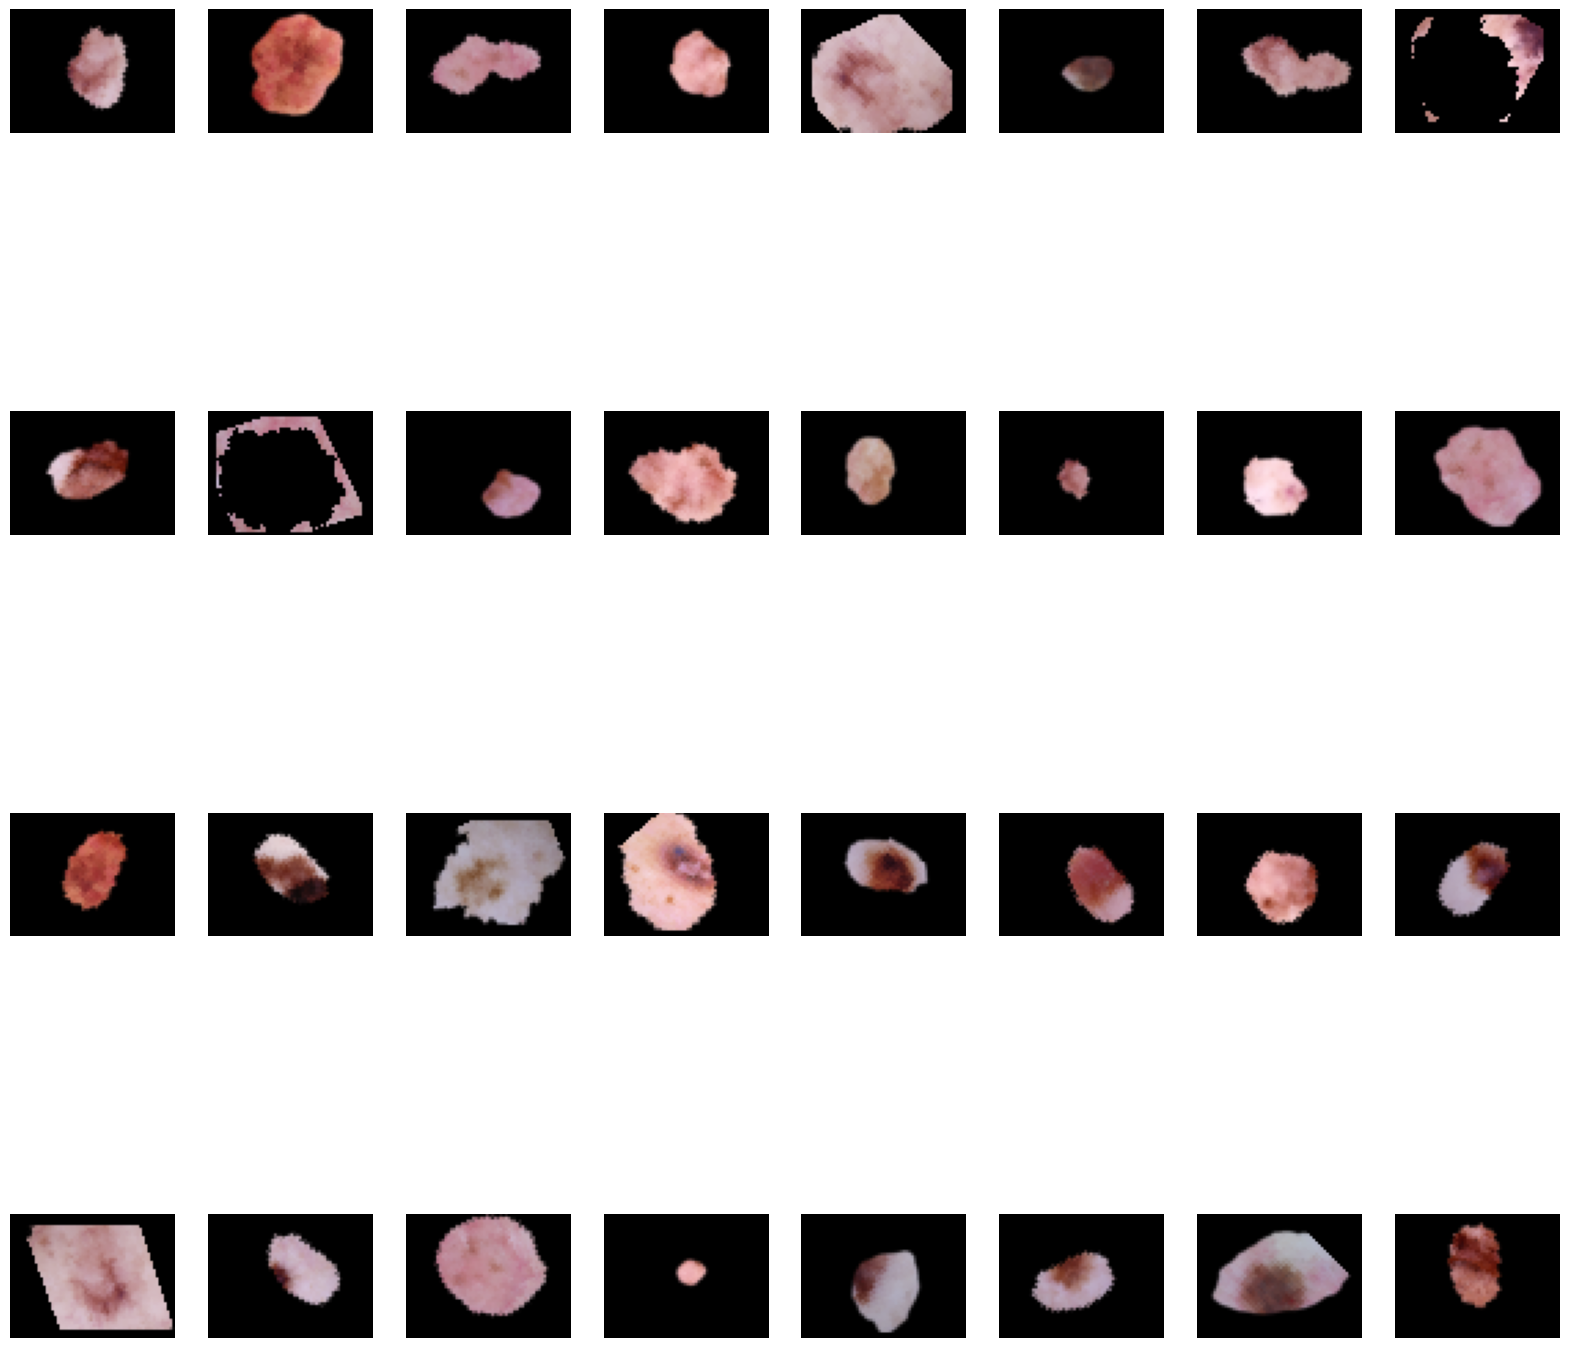

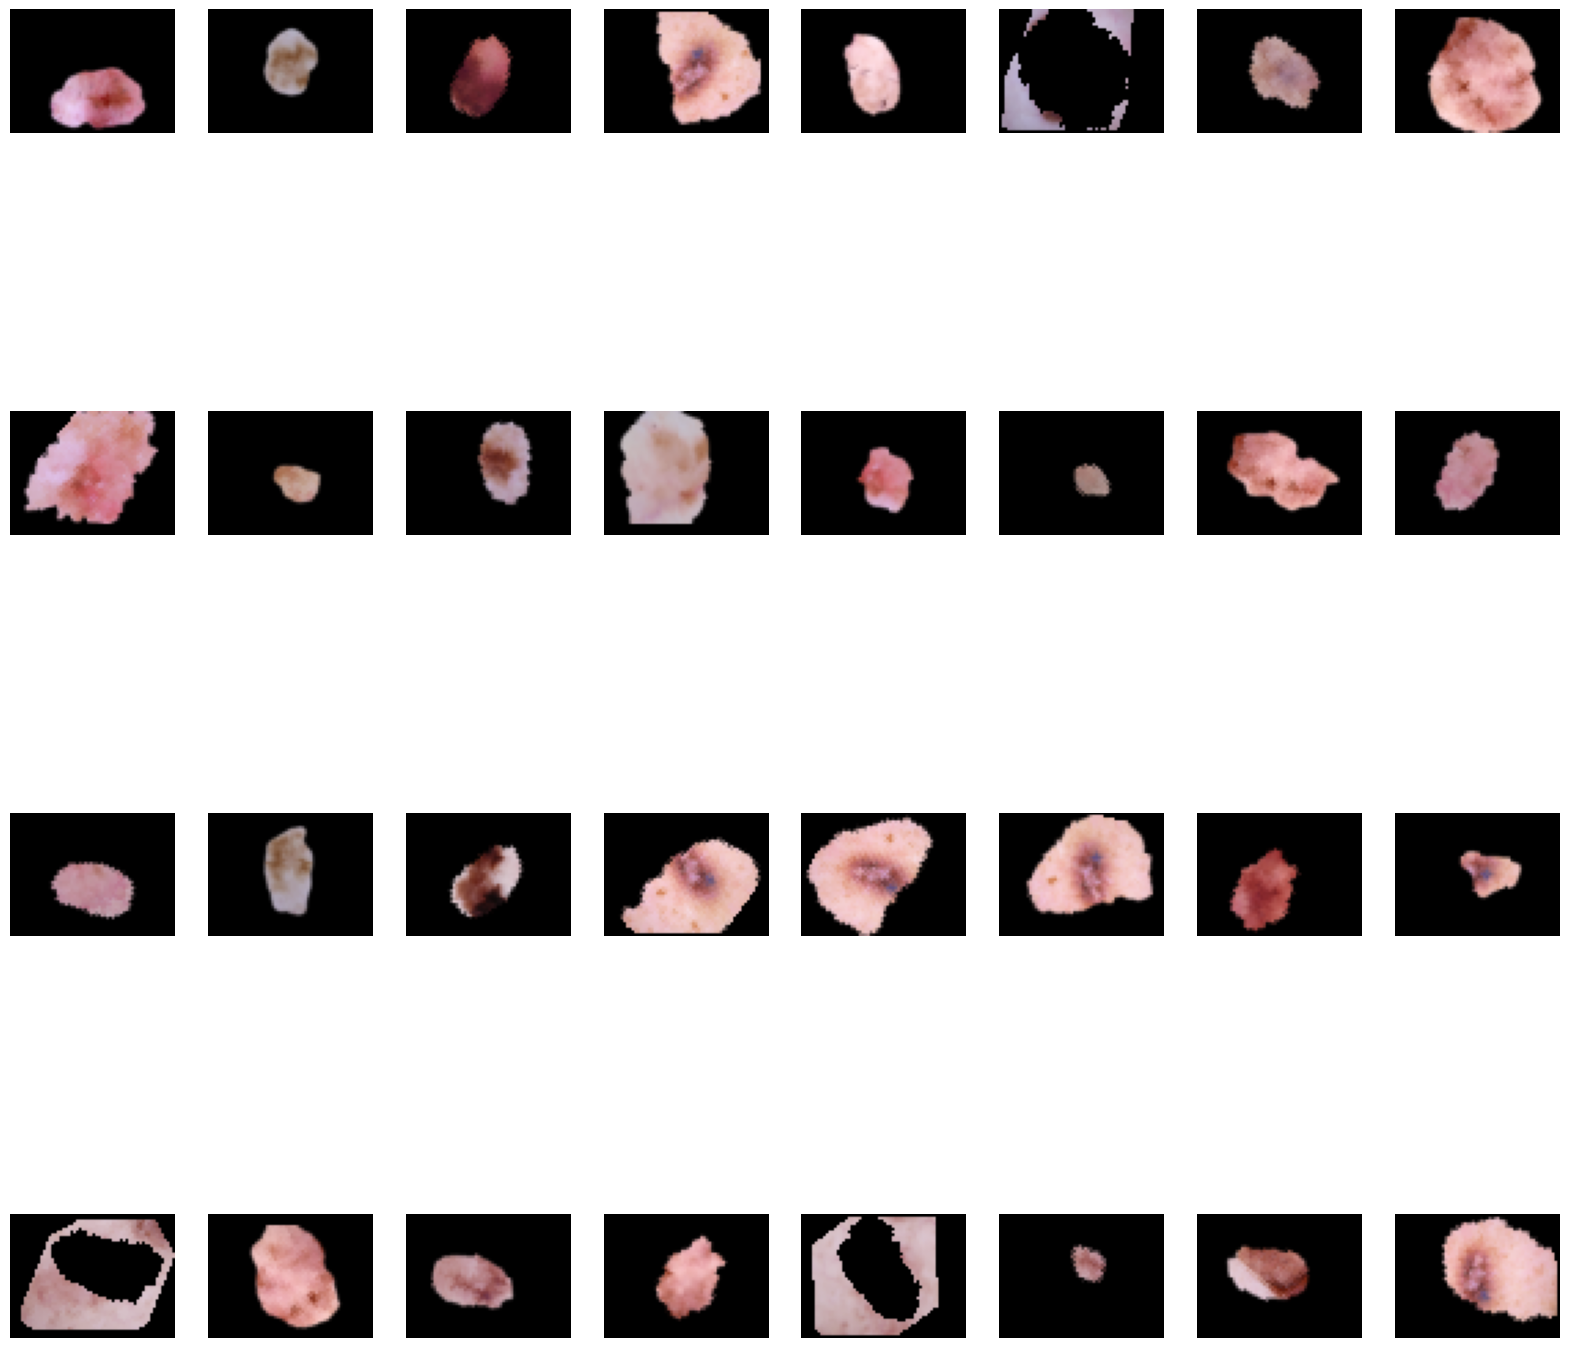

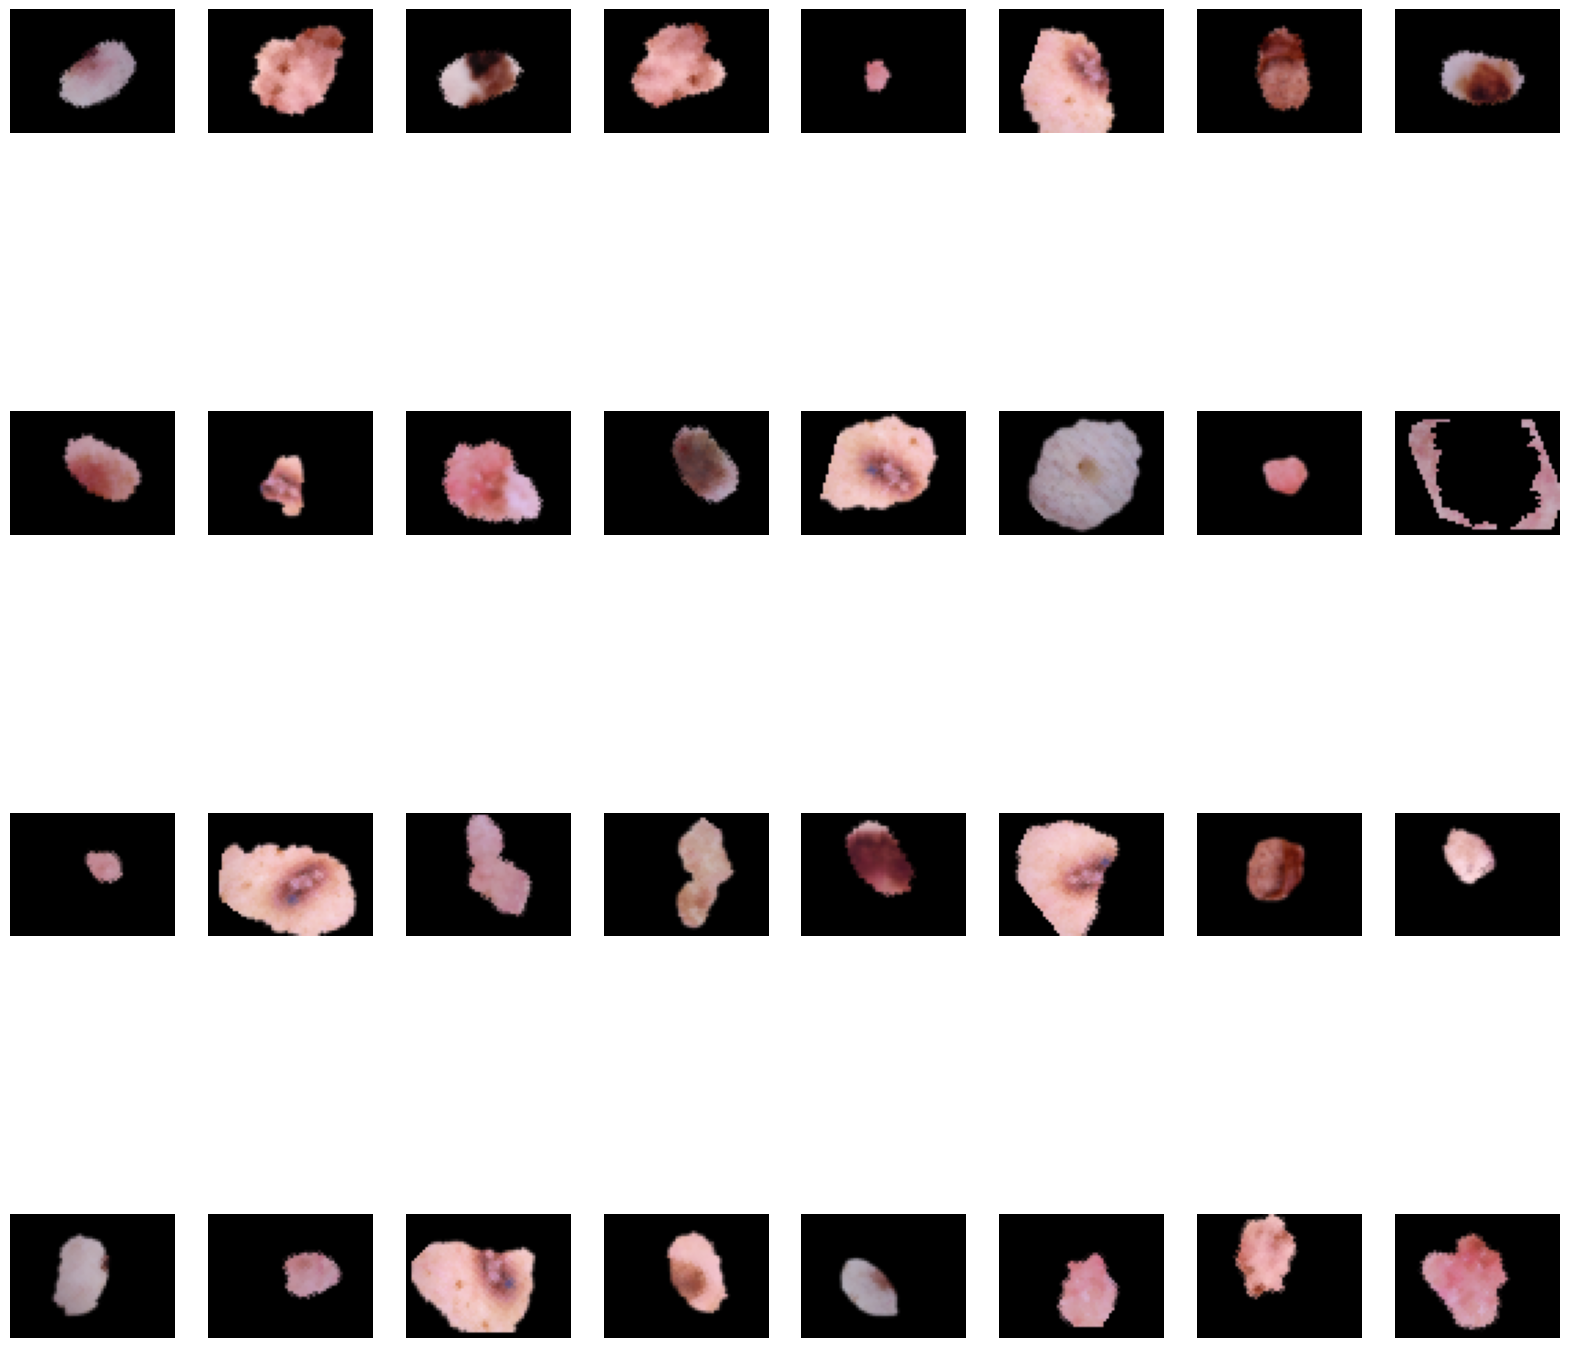

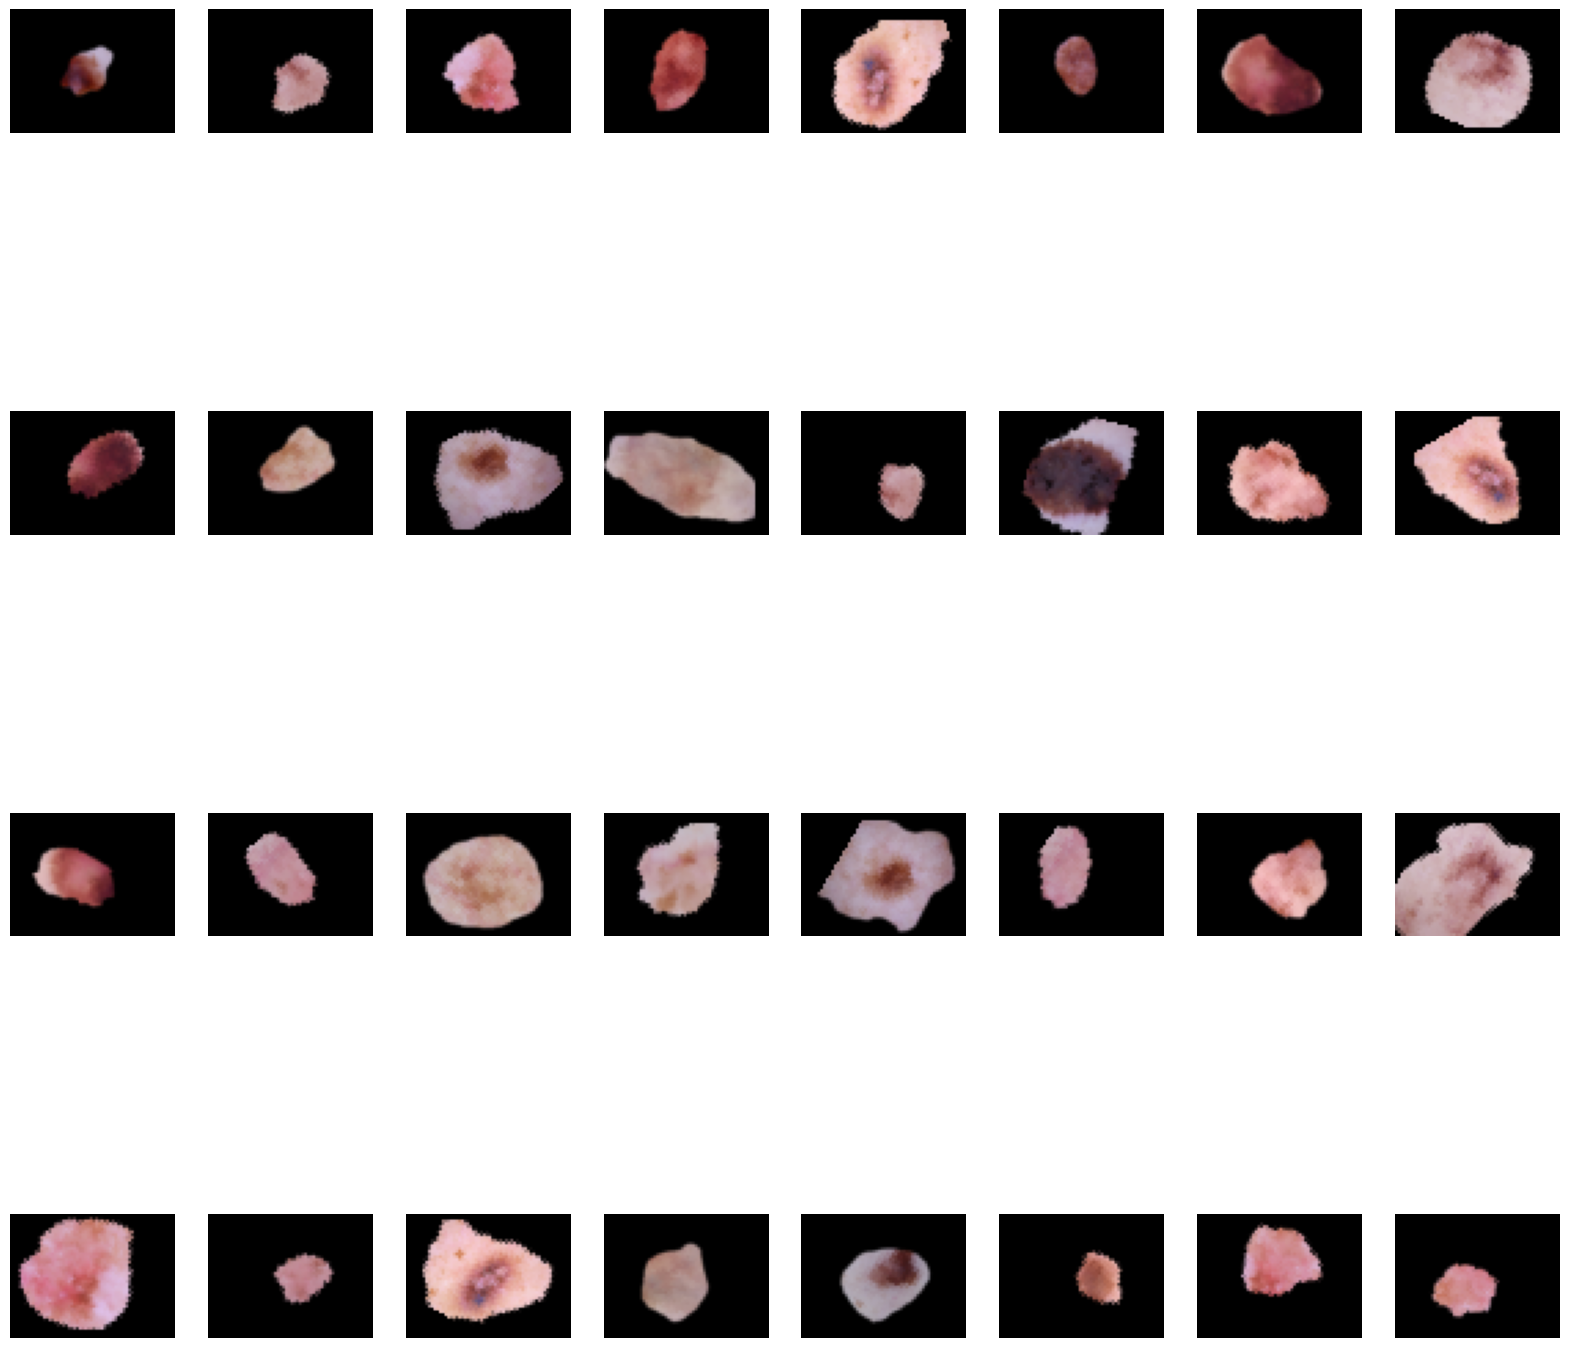

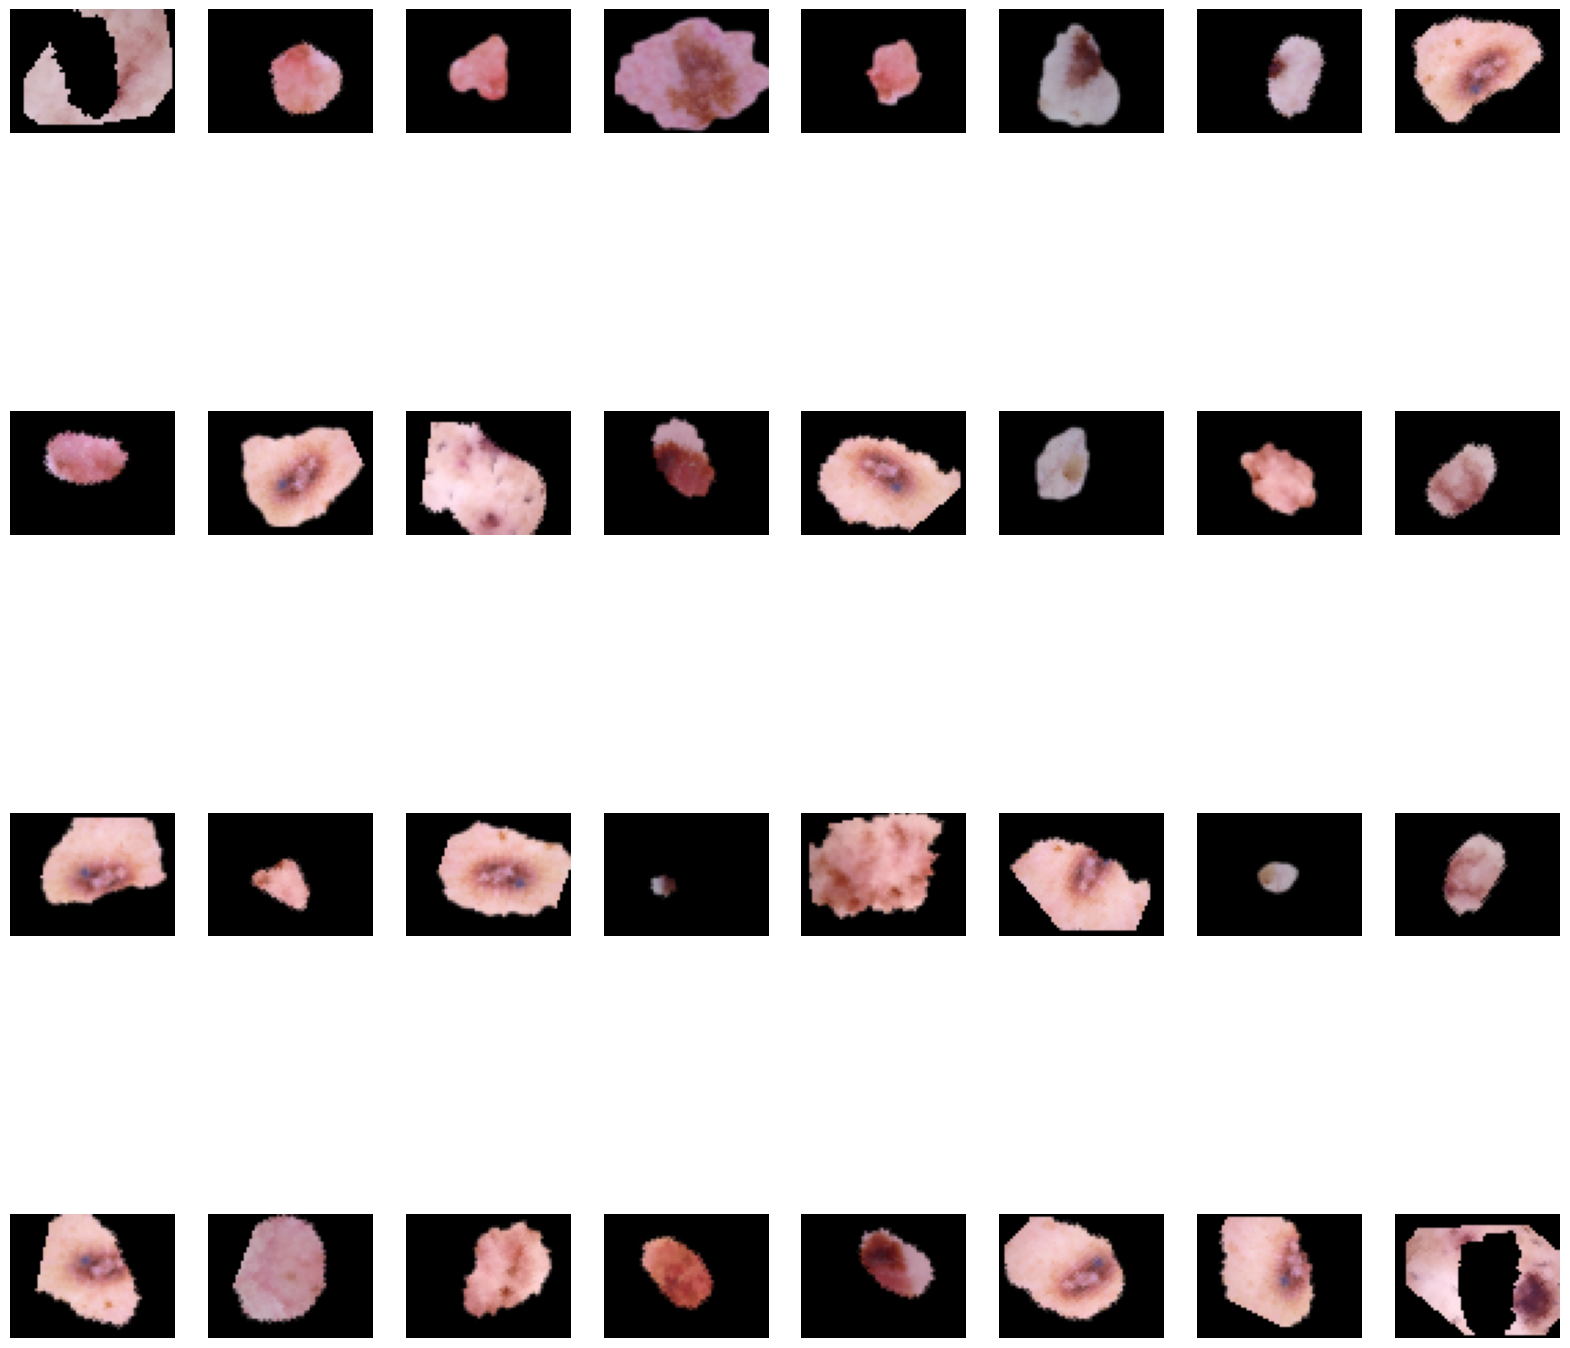

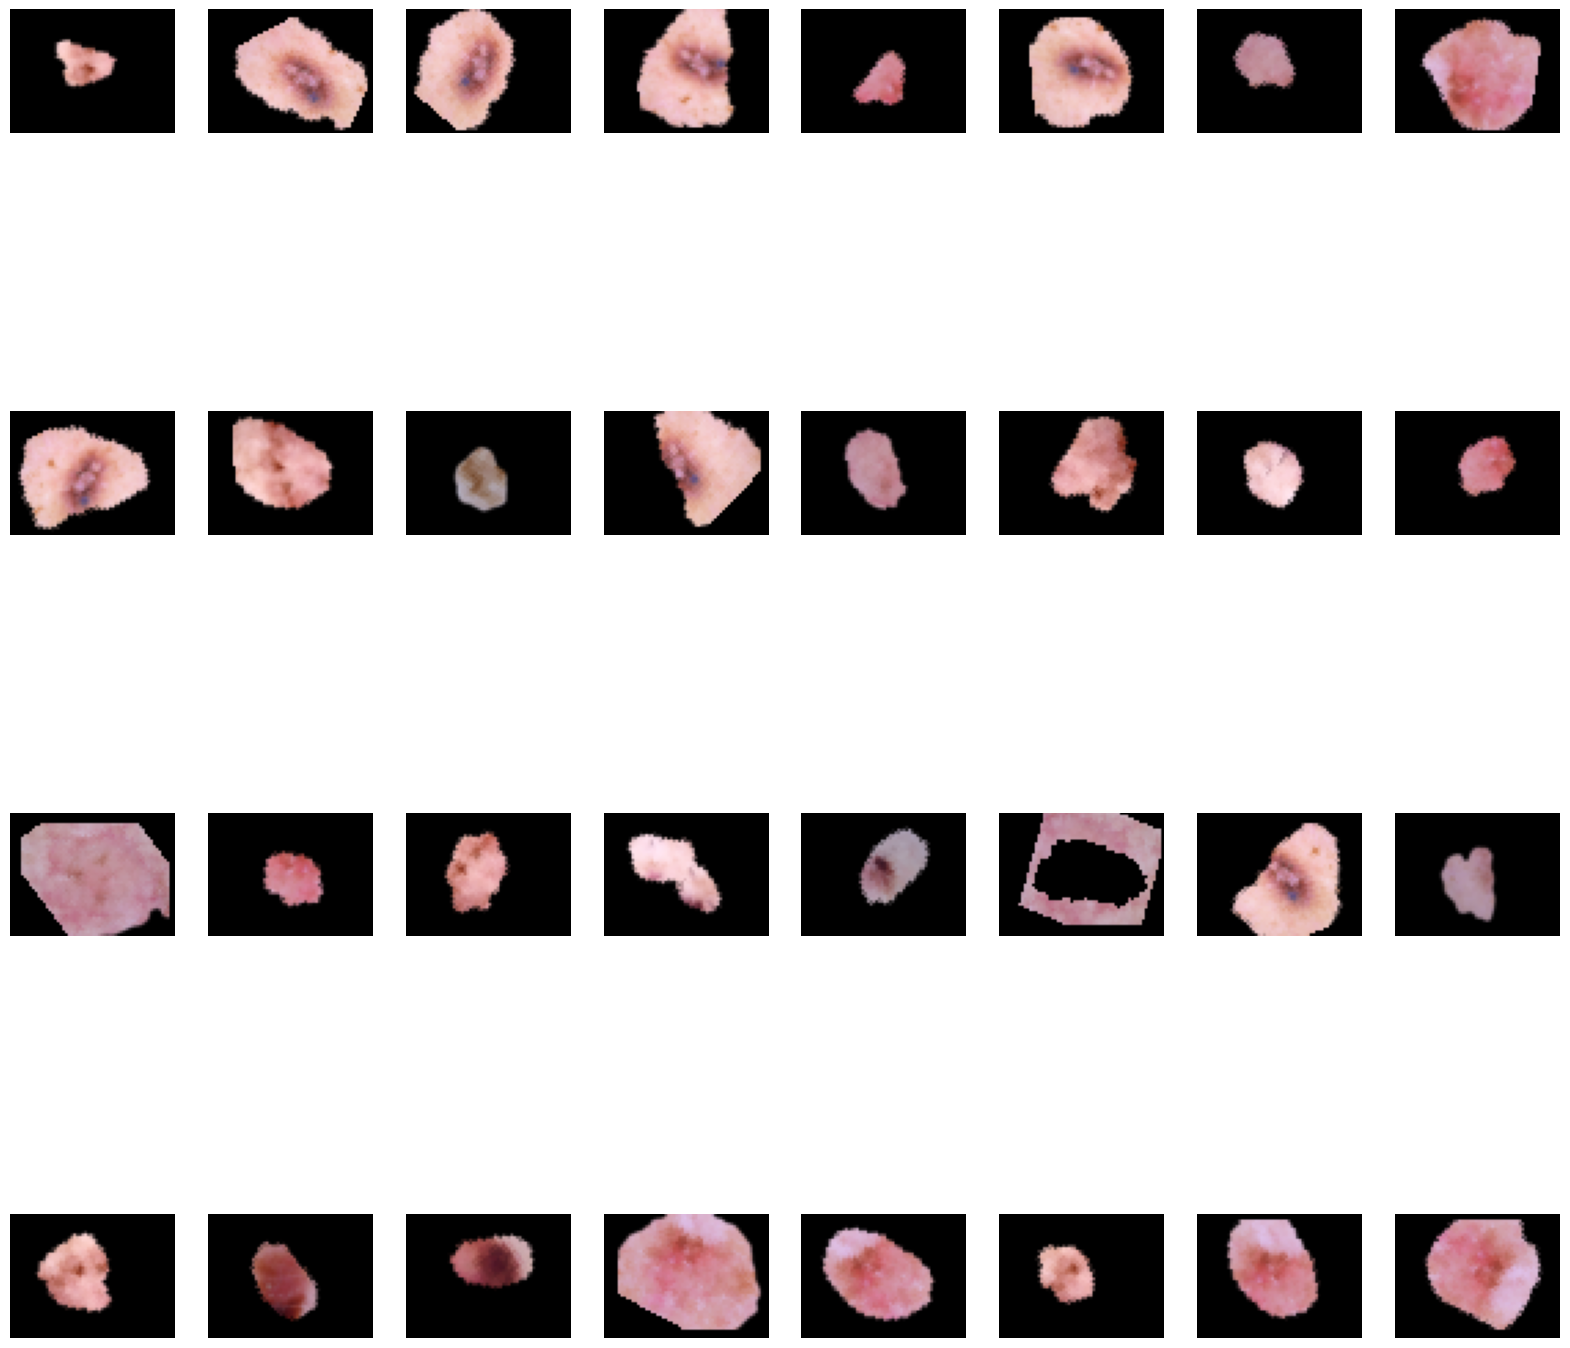

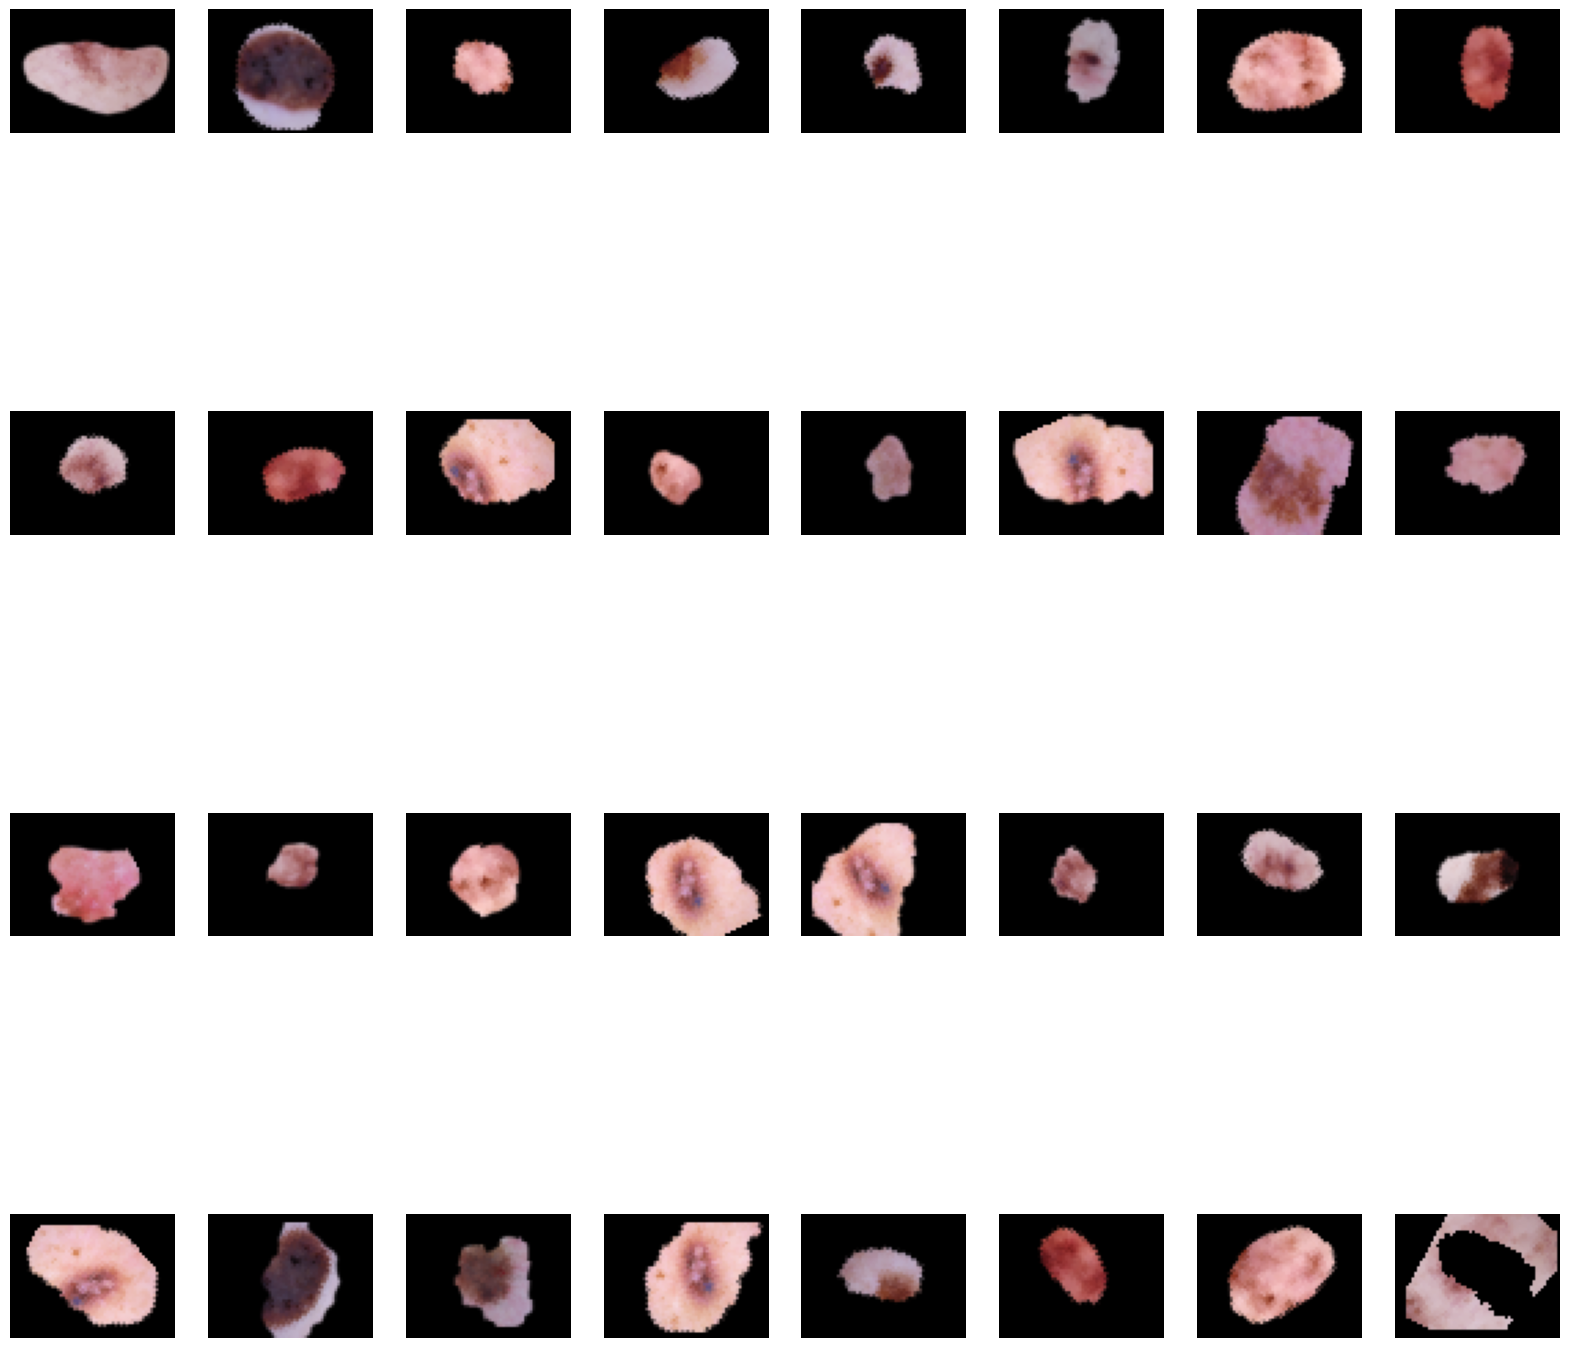

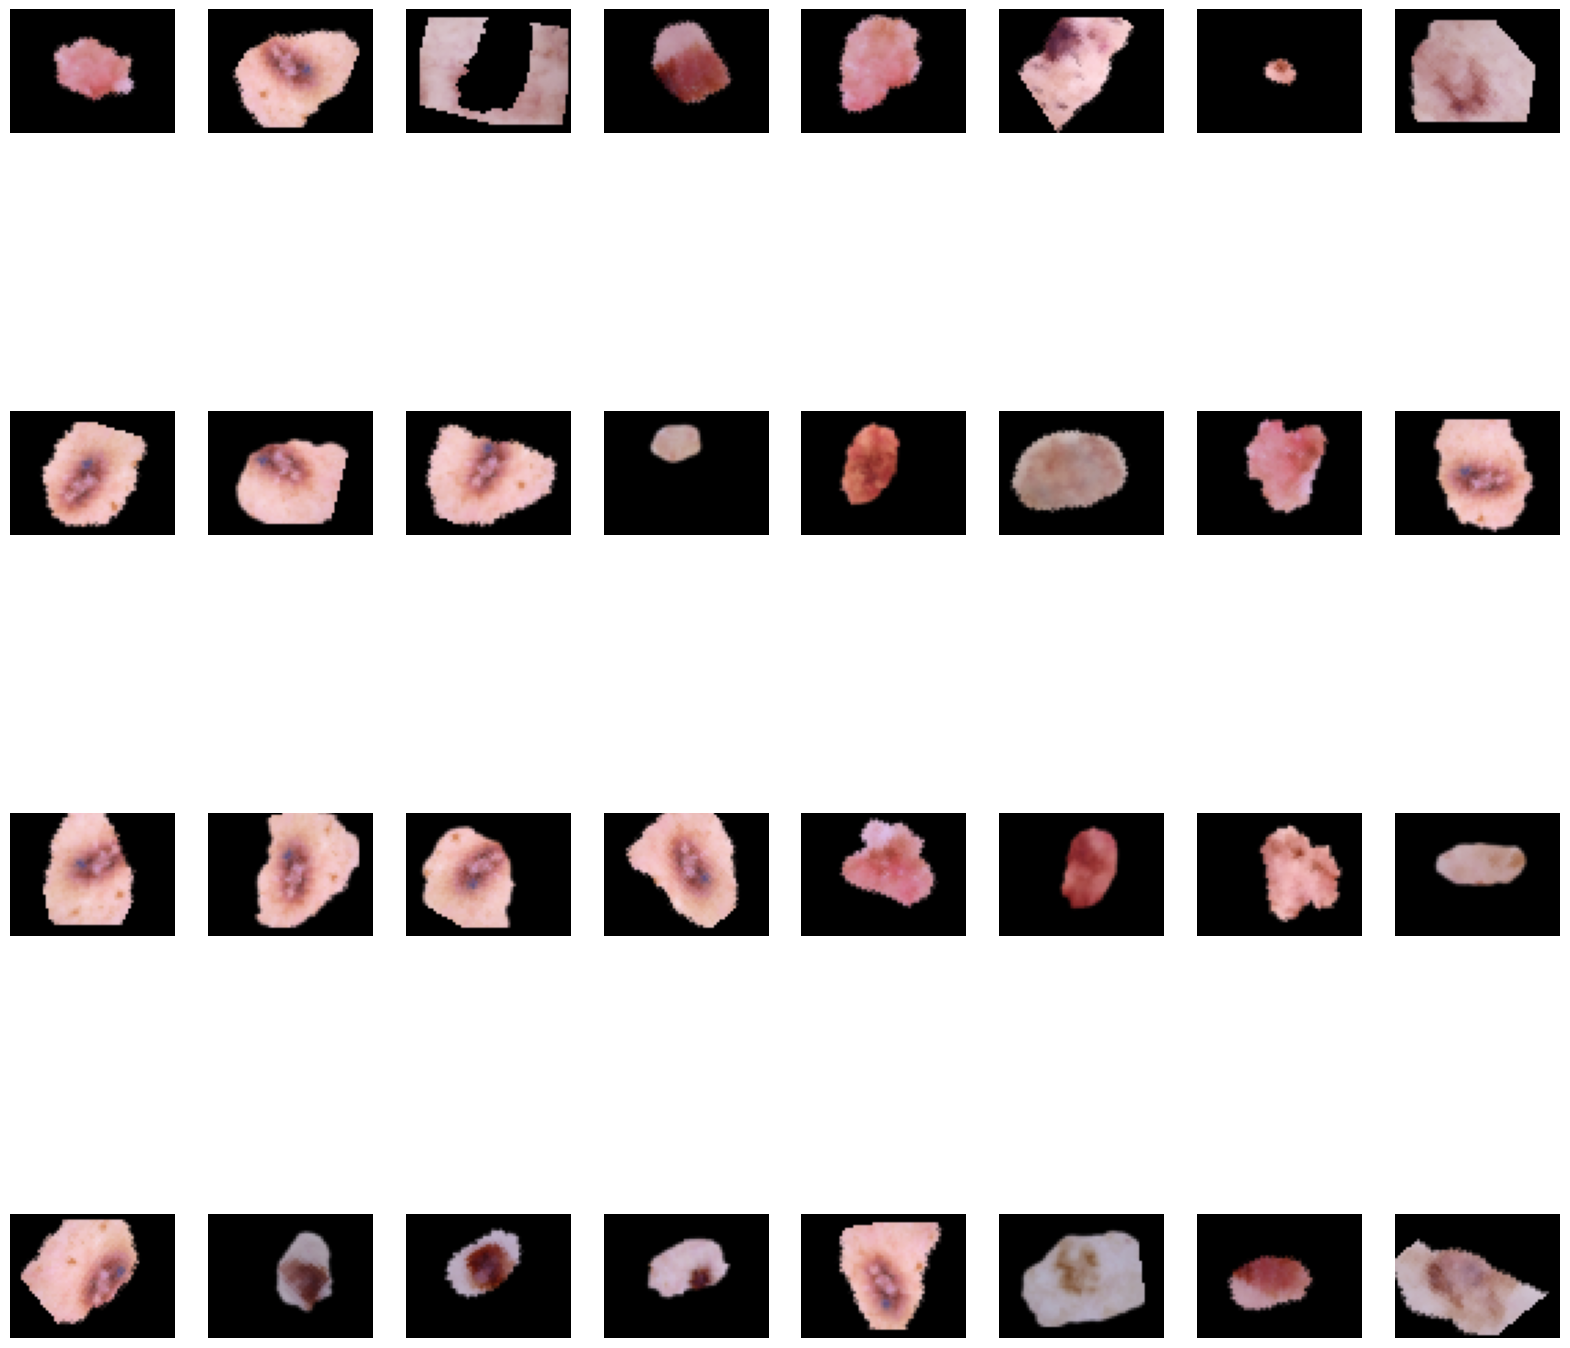

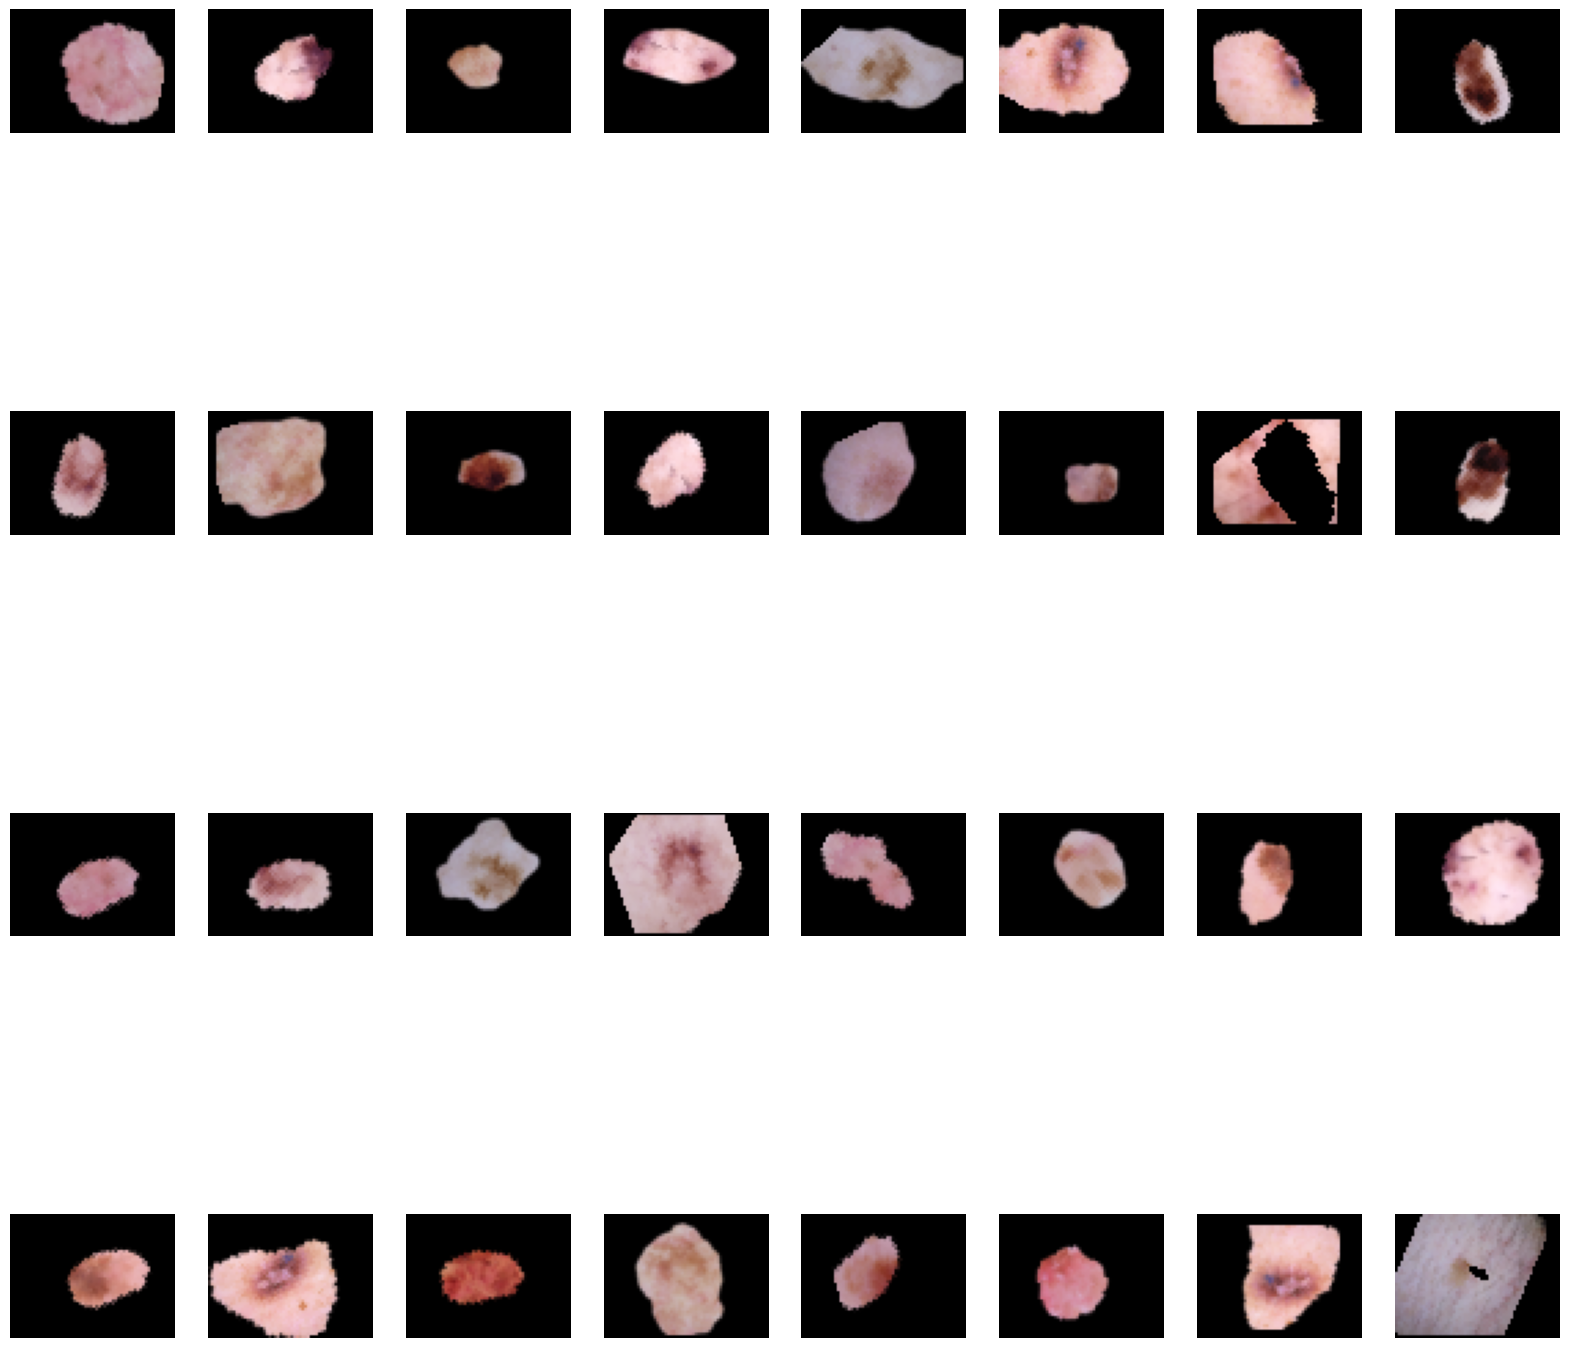

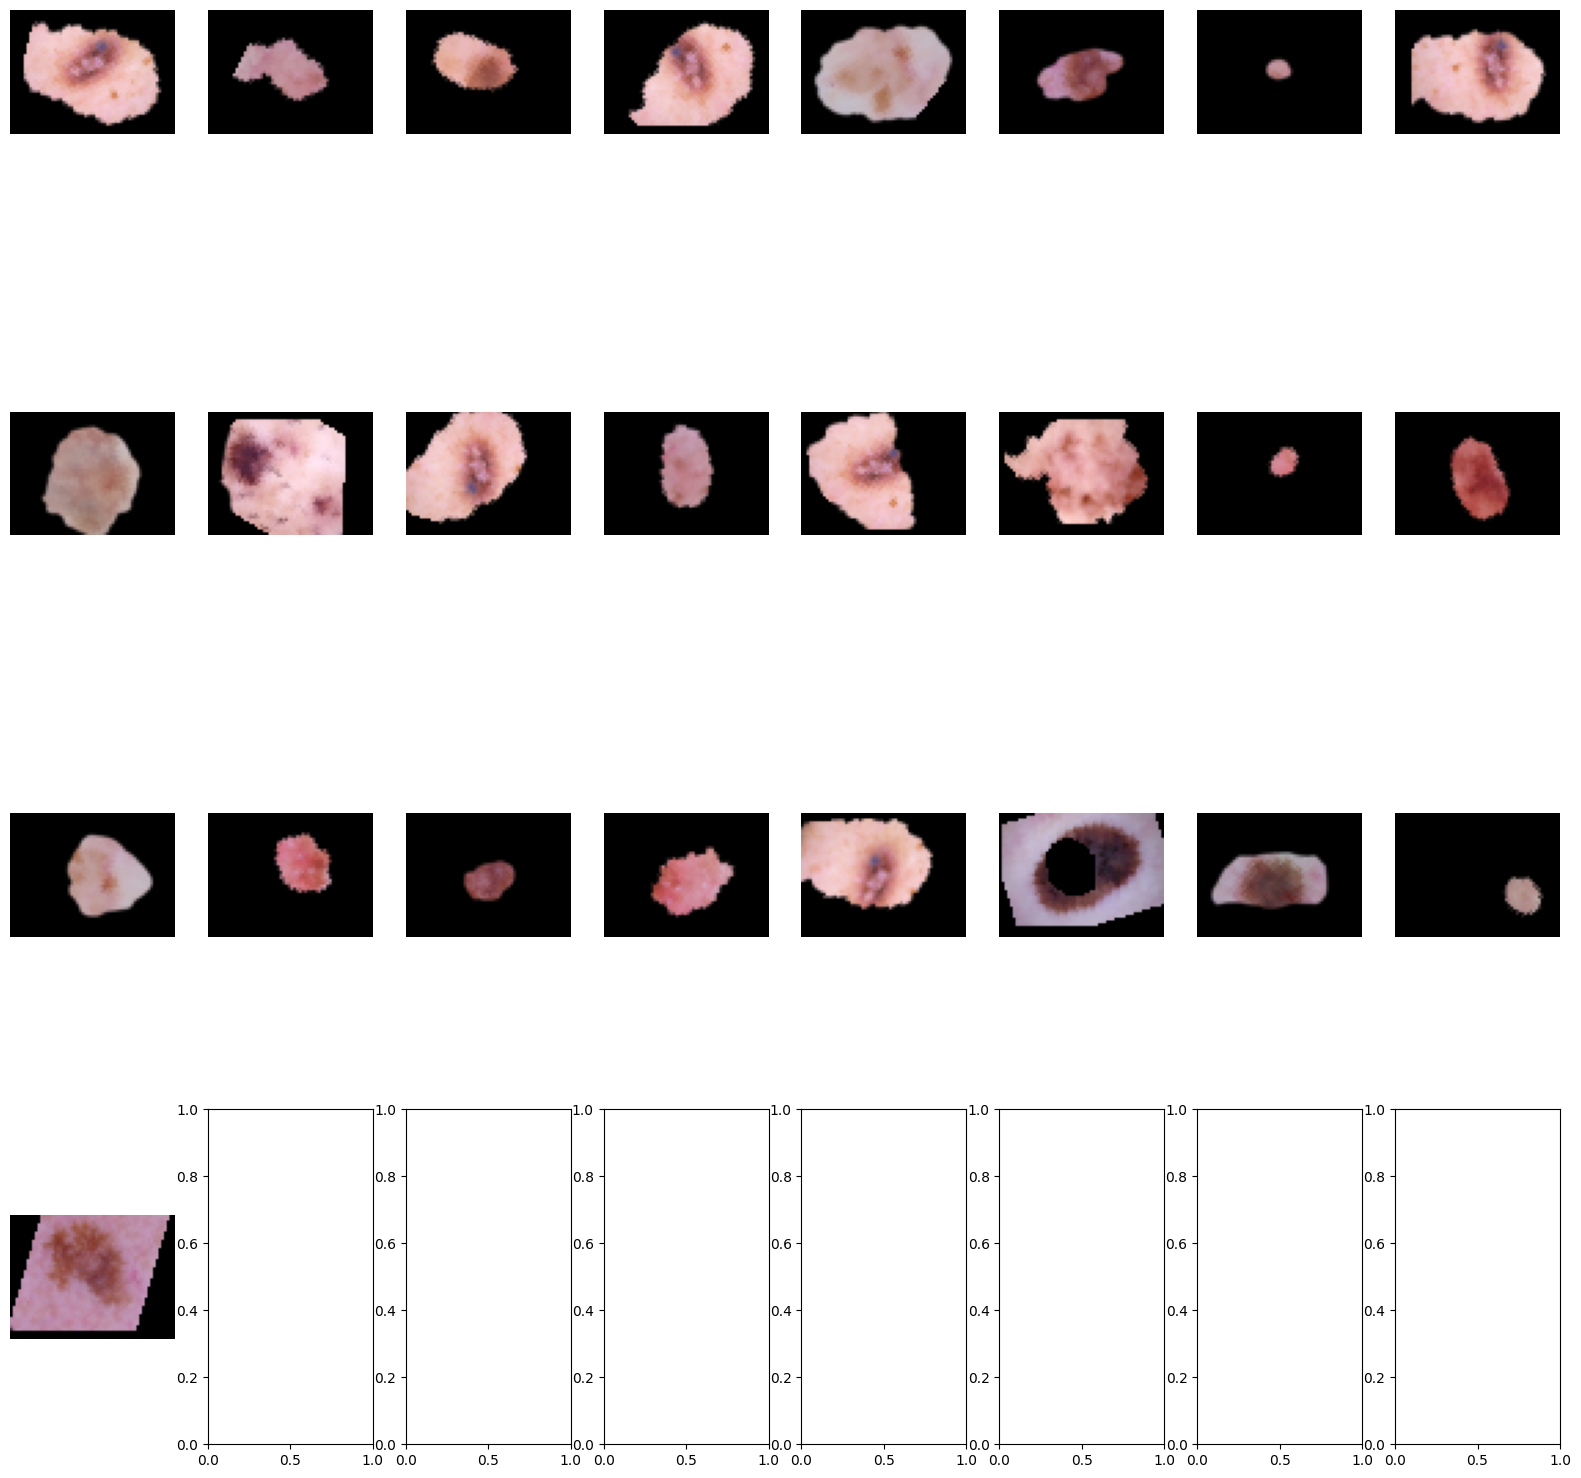

In [8]:
for (batch, labels, segmentations) in train_loader:
        masked_image = torch.mul(batch, segmentations)
        masked_image = masked_image.to(device)

        num_images = masked_image.shape[0]
        rows = 4
        cols = 8

        fig, axes = plt.subplots(rows, cols, figsize=(20, 20))

        for i in range(rows):
            for j in range(cols):
                if i * cols + j < num_images:
                    axes[i, j].imshow(np.transpose(masked_image[i * cols + j], (1, 2, 0)))
                    axes[i, j].axis('off')

        plt.show()

In [ ]:
class CNN(nn.Module):
    def __init__(self, input_size, hidden_layers, num_classes, norm_layer=None):
        super(CNN, self).__init__()
        layers = []
        for l in range(len(hidden_layers)):
            input_layer = input_size if l==0 else hidden_layers[l-1]
            layers.append(nn.Conv2d(in_channels=input_layer, out_channels=hidden_layers[l], kernel_size=3, stride=1, padding=1))
            if (norm_layer == 'BN'):
                layers.append(nn.BatchNorm2d(hidden_layers[l]))
            layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.1))

        layers.append(nn.Flatten()) #Flattening the images for the linear model
        layers.append(nn.Linear(hidden_layers[-1]*input_size*2, num_classes))

        self.layers = nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.layers(x)
        return out

In [126]:
# TO DO: Add normalization layer
model = CNN(INPUT_SIZE, HIDDEN_SIZE, NUM_CLASSES, norm_layer='BN').to(device)
model.apply(weights_init)
print(model)

CNN(
  (layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ReLU()
    (4): Dropout(p=0.25, inplace=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): ReLU()
    (9): Dropout(p=0.25, inplace=False)
    (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): ReLU()
    (14): Dropout(p=0.25, inplace=False)
    (15): Conv2d(128, 256, kernel_size=(3, 3), stride

In [131]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=REG)

In [130]:
for batch_idx, (images, labels, _) in enumerate(train_loader):
    # Print the size of each image in the batch
    print(f"Batch {batch_idx + 1}, Image size: {images.size()}")

Batch 1, Image size: torch.Size([32, 3, 45, 60])
Batch 2, Image size: torch.Size([32, 3, 45, 60])
Batch 3, Image size: torch.Size([32, 3, 45, 60])
Batch 4, Image size: torch.Size([32, 3, 45, 60])
Batch 5, Image size: torch.Size([32, 3, 45, 60])
Batch 6, Image size: torch.Size([32, 3, 45, 60])
Batch 7, Image size: torch.Size([32, 3, 45, 60])
Batch 8, Image size: torch.Size([32, 3, 45, 60])
Batch 9, Image size: torch.Size([32, 3, 45, 60])
Batch 10, Image size: torch.Size([32, 3, 45, 60])
Batch 11, Image size: torch.Size([32, 3, 45, 60])
Batch 12, Image size: torch.Size([32, 3, 45, 60])
Batch 13, Image size: torch.Size([32, 3, 45, 60])
Batch 14, Image size: torch.Size([32, 3, 45, 60])
Batch 15, Image size: torch.Size([32, 3, 45, 60])
Batch 16, Image size: torch.Size([32, 3, 45, 60])
Batch 17, Image size: torch.Size([32, 3, 45, 60])
Batch 18, Image size: torch.Size([32, 3, 45, 60])
Batch 19, Image size: torch.Size([32, 3, 45, 60])
Batch 20, Image size: torch.Size([32, 3, 45, 60])
Batch 21,

In [132]:
total_step = len(train_loader)
loss_train = []
loss_val = []
best_accuracy = None
accuracy_val = []
best_model = type(model)(INPUT_SIZE, HIDDEN_SIZE, NUM_CLASSES, norm_layer='BN') # get a new instance
for epoch in range(N_EPOCHS):
    model.train()
    loss_iter = 0
    for i, (images, labels, _) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images) #Prediction
        loss = loss_function(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_iter += loss.item()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, N_EPOCHS, i+1, total_step, loss.item()))
            
    loss_train.append(loss_iter/(len(train_loader)*BATCH_SIZE))

    LR *= LR_DECAY
    update_lr(optimizer, LR)

    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        loss_iter = 0
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            loss = loss_function(outputs, labels)
            loss_iter += loss.item()
        
        loss_val.append(loss_iter/(len(val_loader)*BATCH_SIZE))

        accuracy = 100 * correct / total
        accuracy_val.append(accuracy)
        print('Validation accuracy is: {} %'.format(accuracy))


Epoch [1/5], Step [100/251], Loss: 1.8573
Epoch [1/5], Step [200/251], Loss: 1.2648
Validation accuracy is: 11.28307538691962 %
Epoch [2/5], Step [100/251], Loss: 0.7803
Epoch [2/5], Step [200/251], Loss: 0.9780
Validation accuracy is: 11.28307538691962 %
Epoch [3/5], Step [100/251], Loss: 1.1163
Epoch [3/5], Step [200/251], Loss: 1.1284
Validation accuracy is: 11.28307538691962 %
Epoch [4/5], Step [100/251], Loss: 0.8292
Epoch [4/5], Step [200/251], Loss: 1.0162
Validation accuracy is: 11.28307538691962 %
Epoch [5/5], Step [100/251], Loss: 0.6098
Epoch [5/5], Step [200/251], Loss: 0.9156
Validation accuracy is: 11.28307538691962 %


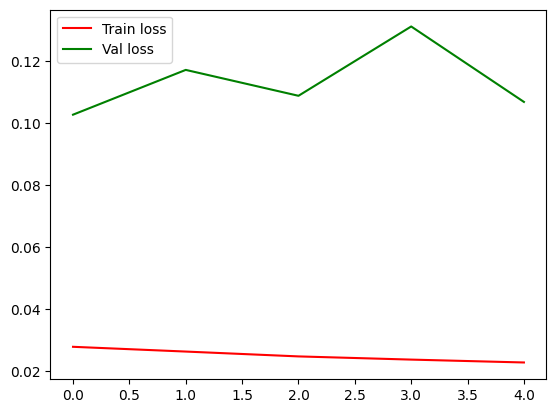

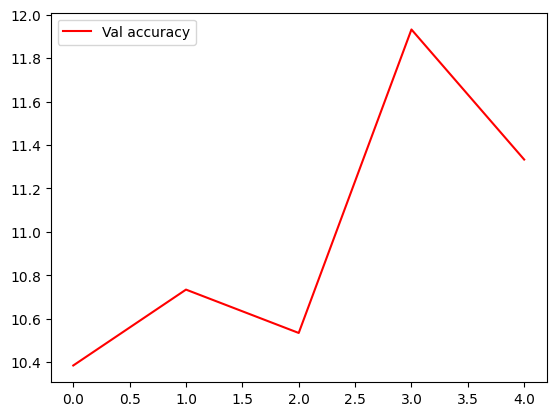

In [111]:
model.eval()

plt.figure(2)
plt.plot(loss_train, 'r', label='Train loss')
plt.plot(loss_val, 'g', label='Val loss')
plt.legend()
plt.show()

plt.figure(3)
plt.plot(accuracy_val, 'r', label='Val accuracy')
plt.legend()
plt.show()